# Arithmetic Dataset Description

This document describes the dataset files generated for **INLP Assignment 5**, which involves training an encoder-decoder Transformer model to perform arithmetic operations (addition and subtraction) on character sequences (e.g., `"123+45"` → `"168"`). The datasets are designed to support core learning, generalization testing, and edge case evaluation.

## Overview

The datasets are stored in CSV format and split into:

- **Training and validation sets** → `arithmetic_datasets_v3/`
- **Edge case test sets** → `arithmetic_datasets_edge_cases/`

Each CSV contains:
- `expression`: A string representing the arithmetic operation (e.g., `"123+45"`)
- `result`: The correct computed value (e.g., `"168"`)
- `tag`: Included only in edge case files, indicating the type (e.g., `"carry"`)

The dataset is designed with a balanced operation mix (50% addition, 50% subtraction) and explicit edge cases to support error analysis and generalization testing.

---

## Dataset Files

### **1. `train.csv` (Training Set)**
- **Location**: `arithmetic_datasets_v3/train.csv`
- **Samples**: 30,000  
- **Operand Count**: 80% with 2 operands, 20% with 3 operands  
- **Operand Length**: 2–4 digits  
- **Edge Cases**:
  - 15% negative numbers
  - 10% zero operands/results
  - 10% leading zeros
  - 10% carry/borrow operations  
- **Purpose**: Core learning set, exposing model to diverse patterns

---

### **2. `val.csv` (Validation Set)**
- **Location**: `arithmetic_datasets_v3/val.csv`
- **Samples**: 2,000  
- **Operand Count**: 80% with 2 operands, 20% with 3 operands  
- **Operand Length**: 2–5 digits  
- **Edge Cases**: Same as train  
- **Purpose**: Used during training for early stopping and hyperparameter tuning

---

### **3. `test1.csv` (Extrapolation Set)**
- **Location**: `arithmetic_datasets_edge_cases/test1.csv`
- **Samples**: 2,000  
- **Operands**: 2  
- **Operand Length**: 5–7 digits  
- **Includes**:
  - 500 long operand samples
  - 300 negative results
  - 300 leading zeros
  - 200 carry cases
  - 200 borrow cases
  - 500 standard samples  
- **Purpose**: Tests generalization to unseen digit lengths

---

### **4. `test2.csv` (Carry/Borrow Stress Set)**
- **Location**: `arithmetic_datasets_edge_cases/test2.csv`
- **Samples**: 2,000  
- **Operands**: 2  
- **Operand Length**: 2–7 digits  
- **Includes**:
  - 500 carry-heavy cases
  - 500 borrow-heavy cases
  - 300 negatives
  - 300 with leading zeros
  - 400 normal samples  
- **Purpose**: Tests robustness under numeric reasoning stress

---

### **5. `test3.csv` (Multi-step Generalization)**
- **Location**: `arithmetic_datasets_edge_cases/test3.csv`
- **Samples**: 2,000  
- **Operands**: 3  
- **Operand Length**: 2–4 digits  
- **Includes**:
  - 1,000 multi-operand cases
  - 300 negative results
  - 300 leading zeros
  - 200 carry cases
  - 200 borrow cases  
- **Purpose**: Tests generalization to longer operand chains (multi-step)

---

## Edge Case Diagnostic Files

These are used for focused error analysis and are stored in `arithmetic_datasets_edge_cases/`.

| File                | Purpose                          | Samples | Tag           |
|---------------------|----------------------------------|---------|----------------|
| `carry_cases.csv`   | Multi-digit carry addition       | 500     | `carry`        |
| `borrow_cases.csv`  | Subtraction with borrow required | 500     | `borrow`       |
| `negative_results.csv` | Negative outputs              | 500     | `negative`     |
| `leading_zeros.csv` | Leading zero handling            | 500     | `leading_zero` |
| `long_operands.csv` | 6–7 digit operand extrapolation  | 500     | `long_operand` |
| `three_operand.csv` | Three operand sequences          | 500     | `three_operand`|

---

## Dataset Characteristics

- **Vocabulary**: Digits `0–9`, symbols `+`, `-`, `=`, and special tokens for padding/start/end  
- **Edge Cases**: Present in all sets for robustness (negatives, carries, etc.)  
- **Generalization**:  
  - `test1` → tests longer operands  
  - `test3` → tests additional operand counts  
- **Efficiency**:  
  - Train on 30K  
  - Validate/Test on 2K  
  - Suitable for Colab-based training  
- **Reproducibility**:  
  - Fixed random seeds: 42 for train/val, 43 for edge sets

---

## Evaluation Metrics

Used in Parts 3 & 4 of the assignment:

- **Exact Match Accuracy**  
- **Character-Level Accuracy**  
- **Perplexity** (optional for interpretability)

---

## Usage Summary

- **Train**: `train.csv`  
- **Validate**: `val.csv`  
- **Evaluate**: `test1.csv`, `test2.csv`, `test3.csv`  
- **Error Analysis**: individual edge case files

---

## References

- Harvard University. *Learn to do arithmetic by sequence modeling*
- castorini. *transformers-arithmetic* GitHub repo  
- thomasahle. *arithmetic-transformer* GitHub repo  
- Zhou et al., (2023). *Teaching Arithmetic to Small Transformers*. arXiv:2307.03381  
- Zhang et al., (2024). *Transformers Can Do Arithmetic with the Right Embeddings*. arXiv:2405.17399


In [ ]:
import csv
import random
import os

# === Config ===
random.seed(42)
train_val_seed = 42
edge_case_seed = 43

# Output directories
trainValDir = "arithmetic_datasets_v3"
edgeCaseDir = "arithmetic_datasets_edge_cases"
os.makedirs(trainValDir, exist_ok=True)
os.makedirs(edgeCaseDir, exist_ok=True)

# Dataset split sizes
splitSizes = {
    "train": 30000,
    "val": 2000,
}

# Operand length configuration
lengthsTrainVal = (2, 4)
lengthsValMax = (2, 5)
lengths2to4 = (2, 4)
lengths2to7 = (2, 7)
lengths6to7 = (6, 7)

# Operand type ratios for train/val
trainOperandRatio = (0.80, 0.20)  # (2-op%, 3-op%)

# Edge case proportions
edgeRatios = {
    "negatives": 0.15,
    "zeros": 0.10,
    "leading": 0.10,
    "carry_borrow": 0.10,
}

# Samples per edge case file
nSamplesPerEdgeCase = 500

# Vocabulary
vocab = {str(i): i for i in range(10)}
vocab.update({'+': 10, '-': 11, '=': 12, '<PAD>': 13, '<SOS>': 14, '<EOS>': 15})

# === Safe Evaluation Function ===
def safeEval(expr):
    try:
        # Replace multiple operators (e.g., -- or +-) with single operator
        expr = expr.replace('--', '+').replace('+-', '-').replace('-+', '-').replace('++', '+')
        # Evaluate left-to-right by splitting and processing sequentially
        tokens = []
        current = ""
        i = 0
        while i < len(expr):
            if expr[i] in "+-" and current:
                tokens.append(current)
                tokens.append(expr[i])
                current = ""
            else:
                current += expr[i]
            i += 1
        if current:
            tokens.append(current)

        # Compute result sequentially
        result = int(tokens[0])
        for i in range(1, len(tokens), 2):
            op = tokens[i]
            num = int(tokens[i + 1])
            if op == '+':
                result += num
            elif op == '-':
                result -= num
        return str(result)
    except Exception as e:
        print(f"Error evaluating {expr}: {e}")
        return None

# === Utility Functions ===
def sampleNumber(length, leadingZeros=False):
    if leadingZeros:
        num = random.randint(0, 10**length - 1)
        return str(num).zfill(length)
    else:
        return str(random.randint(10**(length - 1), 10**length - 1))

def writeCsv(path, rows, headers=["expression", "result"]):
    with open(path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(rows)

def tokenize(expr, result, max_seq_len=20):
    src = expr + '='
    tgt = result + '<EOS>'
    src_tokens = [vocab['<SOS>']] + [vocab[c] for c in src if c in vocab] + [vocab['<EOS>']]
    tgt_tokens = [vocab['<SOS>']] + [vocab[c] for c in tgt if c in vocab] + [vocab['<EOS>']]
    src_padded = src_tokens + [vocab['<PAD>']] * (max_seq_len - len(src_tokens))
    tgt_padded = tgt_tokens + [vocab['<PAD>']] * (max_seq_len - len(tgt_tokens))
    return src_padded, tgt_padded

# === Main Expression Generator for Train/Val ===
def generateExpression(nOperands, digitRange, useNeg=False, useZero=False, useLead=False, useCarryBorrow=False, operation=None):
    ops = []
    for _ in range(nOperands - 1):
        if operation is None:
            ops.append(random.choice(['+', '-']))  # True 50/50 balance
        else:
            ops.append(operation)
    nums = []
    for _ in range(nOperands):
        length = random.randint(*digitRange)
        if useZero:
            nums.append("0" if random.random() < 0.5 else sampleNumber(length))
        elif useLead:
            nums.append(sampleNumber(length, leadingZeros=True))
        elif useCarryBorrow:
            nums.append(str(10**length - 1))  # e.g., 999
        else:
            nums.append(sampleNumber(length))

    expr = nums[0]
    for op, num in zip(ops, nums[1:]):
        expr += f"{op}{num}"

    result = safeEval(expr)
    if result is None:
        return None
    return expr, result

def generateTrainVal(splitName, count, digitRange, operandRatios):
    random.seed(train_val_seed)
    n2Ratio, n3Ratio = operandRatios
    edge_counts = {k: int(v * count) for k, v in edgeRatios.items()}
    normal_count = count - sum(edge_counts.values())

    rows = []
    # Normal samples
    for _ in range(normal_count):
        nOperands = 2 if random.random() < n2Ratio else 3
        result = generateExpression(nOperands, digitRange)
        if result:
            rows.append(result)

    # Edge case samples
    for _ in range(edge_counts["negatives"]):
        result = generateExpression(2, digitRange, useNeg=True)
        if result and int(result[1]) < 0:  # Ensure negative result
            rows.append(result)
    for _ in range(edge_counts["zeros"]):
        result = generateExpression(2, digitRange, useZero=True, operation='-')
        if result:
            rows.append(result)
    for _ in range(edge_counts["leading"]):
        result = generateExpression(2, digitRange, useLead=True)
        if result:
            rows.append(result)
    for _ in range(edge_counts["carry_borrow"]):
        result = generateExpression(2, digitRange, useCarryBorrow=True, operation='+')
        if result:
            rows.append(result)

    random.shuffle(rows)
    writeCsv(os.path.join(trainValDir, f"{splitName}.csv"), rows)

# === Edge Case Generators ===
def generateCarryCases(n):
    random.seed(edge_case_seed)
    cases = []
    while len(cases) < n:
        length = random.randint(3, 7)
        a = 10**length - 1  # e.g., 999
        b = 1
        expr = f"{a}+{b}"
        res = safeEval(expr)
        if res and int(res) == 10**length:  # Ensure carry (e.g., 1000)
            cases.append((expr, res, "carry"))
    return cases

def generateBorrowCases(n):
    random.seed(edge_case_seed)
    cases = []
    while len(cases) < n:
        length = random.randint(3, 7)
        a = 10**length  # e.g., 1000
        b = 1
        expr = f"{a}-{b}"
        res = safeEval(expr)
        if res and int(res) == 10**length - 1:  # Ensure borrow (e.g., 999)
            cases.append((expr, res, "borrow"))
    return cases

def generateNegativeResults(n):
    random.seed(edge_case_seed)
    cases = []
    while len(cases) < n:
        length = random.randint(2, 7)
        a = random.randint(1, 10**length - 1)
        b = random.randint(a + 1, a + 10**length)
        expr = f"{a}-{b}"
        res = safeEval(expr)
        if res and int(res) < 0:
            cases.append((expr, res, "negative"))
    return cases

def generateLeadingZeros(n):
    random.seed(edge_case_seed)
    cases = []
    while len(cases) < n:
        lenA = random.randint(*lengths2to7)
        lenB = random.randint(*lengths2to7)
        a = sampleNumber(lenA, leadingZeros=True)
        b = sampleNumber(lenB, leadingZeros=True)
        op = '+' if len(cases) % 2 == 0 else '-'  # 50/50 balance
        expr = f"{a}{op}{b}"
        res = safeEval(expr)
        if res:
            cases.append((expr, res, "leading_zero"))
    return cases

def generateLongOperands(n):
    random.seed(edge_case_seed)
    cases = []
    while len(cases) < n:
        lenA = random.randint(*lengths6to7)
        lenB = random.randint(*lengths6to7)
        a = sampleNumber(lenA)
        b = sampleNumber(lenB)
        op = '+' if len(cases) % 2 == 0 else '-'  # 50/50 balance
        expr = f"{a}{op}{b}"
        res = safeEval(expr)
        if res:
            cases.append((expr, res, "long_operand"))
    return cases

def generateThreeOperandCases(n):
    random.seed(edge_case_seed)
    cases = []
    while len(cases) < n:
        lenA = random.randint(*lengths2to4)
        lenB = random.randint(*lengths2to4)
        lenC = random.randint(*lengths2to4)
        a = sampleNumber(lenA)
        b = sampleNumber(lenB)
        c = sampleNumber(lenC)
        ops = [random.choice(['+', '-']), random.choice(['+', '-'])]
        expr = f"{a}{ops[0]}{b}{ops[1]}{c}"
        res = safeEval(expr)
        if res:
            cases.append((expr, res, "three_operand"))
    return cases

# === Generate Test Sets ===
def generateTestSets():
    # Test 1: Extrapolation (5–7 digits, 2 operands)
    test1_rows = []
    test1_rows.extend(generateLongOperands(500))
    test1_rows.extend(generateNegativeResults(300))
    test1_rows.extend(generateLeadingZeros(300))
    test1_rows.extend(generateCarryCases(200))
    test1_rows.extend(generateBorrowCases(200))
    for _ in range(500):
        result = generateExpression(2, lengths6to7)
        if result:
            test1_rows.append((result[0], result[1], "normal"))
    writeCsv(os.path.join(edgeCaseDir, "test1.csv"), test1_rows, headers=["expression", "result", "tag"])

    # Test 2: Carry/Borrow Focused (2–7 digits, 2 operands)
    test2_rows = []
    test2_rows.extend(generateCarryCases(500))
    test2_rows.extend(generateBorrowCases(500))
    test2_rows.extend(generateNegativeResults(300))
    test2_rows.extend(generateLeadingZeros(300))
    for _ in range(400):
        result = generateExpression(2, lengths2to7)
        if result:
            test2_rows.append((result[0], result[1], "normal"))
    writeCsv(os.path.join(edgeCaseDir, "test2.csv"), test2_rows, headers=["expression", "result", "tag"])

    # Test 3: Multi-step (2–4 digits, 3 operands)
    test3_rows = []
    test3_rows.extend(generateThreeOperandCases(1000))
    test3_rows.extend(generateNegativeResults(300))
    test3_rows.extend(generateLeadingZeros(300))
    test3_rows.extend(generateCarryCases(200))
    test3_rows.extend(generateBorrowCases(200))
    writeCsv(os.path.join(edgeCaseDir, "test3.csv"), test3_rows, headers=["expression", "result", "tag"])

# === Generate and Save All ===
generateTrainVal("train", splitSizes["train"], lengthsTrainVal, trainOperandRatio)
generateTrainVal("val", splitSizes["val"], lengthsValMax, trainOperandRatio)
generateTestSets()

print("All datasets generated and saved.")

All datasets generated and saved.


In [ ]:
## To zip dataset, (Don't use this again, just use the gdown link to download dataset)
## It was used to zip the dataset which was prepared for assignment

!zip -r arithmetic_datasets_v3.zip arithmetic_datasets_v3/
!zip -r arithmetic_datasets_edge_cases.zip arithmetic_datasets_edge_cases/

  adding: arithmetic_datasets_v3/ (stored 0%)
  adding: arithmetic_datasets_v3/train.csv (deflated 56%)
  adding: arithmetic_datasets_v3/val.csv (deflated 52%)
  adding: arithmetic_datasets_edge_cases/ (stored 0%)
  adding: arithmetic_datasets_edge_cases/test2.csv (deflated 77%)
  adding: arithmetic_datasets_edge_cases/test3.csv (deflated 71%)
  adding: arithmetic_datasets_edge_cases/test1.csv (deflated 66%)


In [1]:
## gDown link --
!gdown https://drive.google.com/uc?id=1_NtEZyAyIX1iOvUDeqabtkx_8G0q-CzE
!gdown https://drive.google.com/uc?id=1R9rKXfovnHTyCkENPxnQvQk0s2VlovBD


Downloading...
From: https://drive.google.com/uc?id=1_NtEZyAyIX1iOvUDeqabtkx_8G0q-CzE
To: /content/arithmetic_datasets_v3.zip
100% 180k/180k [00:00<00:00, 3.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R9rKXfovnHTyCkENPxnQvQk0s2VlovBD
To: /content/arithmetic_datasets_edge_cases.zip
100% 50.5k/50.5k [00:00<00:00, 6.75MB/s]


In [2]:
## After gDown use this to unpack the dataSet for processing with transformer.
!unzip arithmetic_datasets_v3.zip
!unzip arithmetic_datasets_edge_cases.zip

Archive:  arithmetic_datasets_v3.zip
   creating: arithmetic_datasets_v3/
  inflating: arithmetic_datasets_v3/train.csv  
  inflating: arithmetic_datasets_v3/val.csv  
Archive:  arithmetic_datasets_edge_cases.zip
   creating: arithmetic_datasets_edge_cases/
  inflating: arithmetic_datasets_edge_cases/test2.csv  
  inflating: arithmetic_datasets_edge_cases/test3.csv  
  inflating: arithmetic_datasets_edge_cases/test1.csv  


# Transformer for Arithmetic Reasoning (+/-)

This notebook implements a custom Transformer encoder-decoder model to solve arithmetic expressions using addition and subtraction, as per INLP Assignment 5. The model is trained on a dataset of arithmetic expressions and evaluated for generalization and robustness to edge cases.

### Expression Examples:
- 2 operands: `123+456=579`, `900-23=877`
- 3 operands: `123+45-67=101`

### Generalization Tests:
- Longer operand lengths (5–7 digits)
- Increased operand count (3 operands)
- Edge cases: carries, borrows, negative results, leading zeros

### Dataset Overview
The dataset is stored in `arithmetic_datasets_v3/` (train, validation) and `arithmetic_datasets_edge_cases/` (test sets and edge cases). See `dataset_description.md` for details.

| Split | Samples | Operands | Operand Length | Purpose |
|-------|---------|----------|----------------|---------|
| Train | 30,000 | 2 (80%), 3 (20%) | 2–4 digits | Core learning |
| Val   | 2,000  | 2 (80%), 3 (20%) | 2–5 digits | Generalization to longer digits |
| Test 1 | 2,000 | 2 | 5–7 digits | Extrapolation: operand length |
| Test 2 | 2,000 | 2 | 2–7 digits | Numeric reasoning: carries/borrows |
| Test 3 | 2,000 | 3 | 2–4 digits | Multi-step generalization |

Edge cases (negatives, zeros, leading zeros, carries) are included in all sets, with dedicated edge case files for analysis.

### Training Configuration
- Epochs: 50
- Early stopping patience: 3
- Plots: Accuracy (train/val), Loss (train/val), Character-Level Accuracy (val), Exact Match (val) vs. Epochs

**References**:
- Harvard’s arithmetic modeling project
- castorini/transformers-arithmetic
- arXiv:2307.03381, arXiv:2405.17399

In [3]:
import os
import csv
import random
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Dataset directories
train_val_dir = 'arithmetic_datasets_v3'
edge_case_dir = 'arithmetic_datasets_edge_cases'

# Ensure directories exist
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(edge_case_dir, exist_ok=True)

# Verify dataset
# Verify dataset files
print('Train/Val files:')
for f in os.listdir(train_val_dir):
    print(f'- {f}')
print('\nEdge case/Test files:')
for f in os.listdir(edge_case_dir):
    print(f'- {f}')

# Sample data from train.csv
print('\nSample training data:')
with open(os.path.join(train_val_dir, 'train.csv'), 'r') as f:
    reader = csv.reader(f)
    headers = next(reader)
    print(f'Headers: {headers}')
    for i, row in enumerate(reader):
        if i < 5:
            print(row)
        else:
            break

Using device: cuda
Train/Val files:
- train.csv
- val.csv

Edge case/Test files:
- test3.csv
- test1.csv
- test2.csv

Sample training data:
Headers: ['expression', 'result']
['1970+503', '2473']
['1586-3318', '-1732']
['0-965', '-965']
['53+229', '282']
['6698-264', '6434']


## Vocabulary and Special Tokens

The vocabulary is character-level, covering:
- Digits: `0–9`
- Operators: `+`, `-`, `=`
- Special tokens: `<pad>`, `<sos>`, `<eos>`

The vocabulary is used to tokenize input/output strings into numerical tensors for the Transformer model.

In [4]:
# Vocabulary definition
vocab_symbols = ['<pad>', '<sos>', '<eos>'] + list('0123456789+-=')
vocab_size = len(vocab_symbols)

token_to_id = {token: idx for idx, token in enumerate(vocab_symbols)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

# Special token IDs
pad_id = token_to_id['<pad>']
sos_id = token_to_id['<sos>']
eos_id = token_to_id['<eos>']

print('Vocabulary Size:', vocab_size)
print('Tokens:', token_to_id)

Vocabulary Size: 16
Tokens: {'<pad>': 0, '<sos>': 1, '<eos>': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '+': 13, '-': 14, '=': 15}


## Tokenization and Encoding

Two functions handle tokenization:
- `encode_expression()`: Converts a string (e.g., `123+456=`) into a tensor of token IDs with `<sos>` and `<eos>`.
- `decode_expression()`: Converts token IDs back to a string, excluding special tokens.

These are used in the dataset class and during inference.

In [5]:
def encode_expression(expr, token_to_id, max_len=40, add_sos_eos=True):
    token_ids = []
    if add_sos_eos:
        token_ids.append(token_to_id['<sos>'])

    for char in expr:
        if char in token_to_id:
            token_ids.append(token_to_id[char])
        else:
            raise ValueError(f'Invalid character {char} in expression')

    if add_sos_eos:
        token_ids.append(token_to_id['<eos>'])

    if max_len is not None:
        if len(token_ids) < max_len:
            token_ids += [token_to_id['<pad>']] * (max_len - len(token_ids))
        else:
            token_ids = token_ids[:max_len]

    return torch.tensor(token_ids, dtype=torch.long)

def decode_expression(token_ids, id_to_token):
    tokens = []
    for idx in token_ids:
        token = id_to_token.get(idx, '')
        if token in ['<eos>', '<pad>', '<sos>']:
            if token == '<eos>':
                break
            continue
        tokens.append(token)
    return ''.join(tokens)

## Dataset Class and DataLoader

The `ArithmeticDataset` class loads CSV files from `arithmetic_datasets_v3/` and `arithmetic_datasets_edge_cases/`. Each item returns:
- Source: Tokenized input (e.g., `<sos>123+456=<eos>`).
- Target input: Result shifted right (e.g., `<sos>579`).
- Target output: Result (e.g., `579<eos>`).

The `DataLoader` uses a batch size of 64 and max lengths of 40 (source) and 20 (target) to handle the longest expressions (e.g., 7-digit operands).

In [6]:
class ArithmeticDataset(Dataset):
    def __init__(self, csv_file, token_to_id, max_src_len=40, max_tgt_len=20):
        self.data = []
        self.token_to_id = token_to_id
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len

        try:
            with open(csv_file, 'r') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    self.data.append((row['expression'], row['result']))
        except Exception as e:
            raise ValueError(f'Error reading {csv_file}: {e}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        expr, result = self.data[idx]

        src_tensor = encode_expression(expr, self.token_to_id, self.max_src_len)
        tgt_full = encode_expression(result, self.token_to_id, self.max_tgt_len)

        tgt_input = tgt_full[:-1]
        tgt_output = tgt_full[1:]

        return src_tensor, tgt_input, tgt_output

def get_data_loader(csv_path, token_to_id, batch_size=1024, max_src_len=40, max_tgt_len=20, shuffle=True):
    dataset = ArithmeticDataset(csv_path, token_to_id, max_src_len, max_tgt_len)
    print(f'Loaded dataset with {len(dataset)} samples from {csv_path}')
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

## Load Train, Validation, and Test Data

Load datasets using `get_data_loader`:
- Train: `train.csv` (30K samples)
- Validation: `val.csv` (2K samples)
- Test 1–3: `test1.csv`, `test2.csv`, `test3.csv` (2K each)

Test loaders are not shuffled to ensure consistent evaluation.

In [7]:
train_loader = get_data_loader(os.path.join(train_val_dir, 'train.csv'), token_to_id)
val_loader = get_data_loader(os.path.join(train_val_dir, 'val.csv'), token_to_id)
test1_loader = get_data_loader(os.path.join(edge_case_dir, 'test1.csv'), token_to_id, shuffle=False)
test2_loader = get_data_loader(os.path.join(edge_case_dir, 'test2.csv'), token_to_id, shuffle=False)
test3_loader = get_data_loader(os.path.join(edge_case_dir, 'test3.csv'), token_to_id, shuffle=False)

print('Train batches:', len(train_loader))
print('Validation batches:', len(val_loader))
print('Test 1 batches:', len(test1_loader))
print('Test 2 batches:', len(test2_loader))
print('Test 3 batches:', len(test3_loader))

Loaded dataset with 26606 samples from arithmetic_datasets_v3/train.csv
Loaded dataset with 1763 samples from arithmetic_datasets_v3/val.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test1.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test2.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test3.csv
Train batches: 26
Validation batches: 2
Test 1 batches: 2
Test 2 batches: 2
Test 3 batches: 2


In [8]:
with open("arithmetic_datasets_v3/train.csv", 'r') as f:
    for _ in range(5):
        print(f.readline())

expression,result

1970+503,2473

1586-3318,-1732

0-965,-965

53+229,282



In [9]:
def encodeExpression(expr, tokenToId, maxLen=None, addSosEos=True):
    tokenIds = []

    if addSosEos:
        tokenIds.append(tokenToId['<sos>'])

    for char in expr:
        tokenIds.append(tokenToId.get(char, tokenToId['<unk>']))

    if addSosEos:
        tokenIds.append(tokenToId['<eos>'])

    if maxLen is not None:
        if len(tokenIds) < maxLen:
            tokenIds += [tokenToId['<pad>']] * (maxLen - len(tokenIds))
        else:
            tokenIds = tokenIds[:maxLen]

    return torch.tensor(tokenIds, dtype=torch.long)

def decodeExpression(tokenIds, idToToken):
    tokens = [idToToken.get(idx, '<unk>') for idx in tokenIds]
    result = []

    for token in tokens:
        if token == '<eos>':
            break
        if token not in ['<pad>', '<sos>']:
            result.append(token)

    return ''.join(result)


## Positional Encoding

Transformers lack inherent sequence order. Sinusoidal positional encodings are added to input embeddings to preserve the order of digits, operators, and the equal sign in expressions.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

## Position-wise Feedforward Network

Each Transformer layer includes a feedforward network applied independently to each position, with two linear transformations and ReLU activation. This enhances the model’s capacity for non-linear transformations, critical for arithmetic reasoning.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU()

        # Initialize weights
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

## Encoder and Decoder Layers

**Encoder Layer**:
- Multi-head self-attention
- Position-wise feedforward network
- Residual connections and layer normalization

**Decoder Layer**:
- Masked multi-head self-attention (autoregressive)
- Cross-attention to encoder outputs
- Position-wise feedforward network
- Residual connections and layer normalization

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_uniform_(self.self_attention.in_proj_weight)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.self_attention(x, x, x, attn_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        x = self.norm2(x + self.dropout(self.feed_forward(x)))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.cross_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_uniform_(self.self_attention.in_proj_weight)
        nn.init.xavier_uniform_(self.cross_attention.in_proj_weight)

    def forward(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        self_attn_output, _ = self.self_attention(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        cross_attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, attn_mask=memory_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))

        x = self.norm3(x + self.dropout(self.feed_forward(x)))
        return x

## Encoder and Decoder Stacks

The encoder and decoder are stacks of multiple layers:
- **Encoder**: Embeds tokens, adds positional encodings, and applies encoder layers.
- **Decoder**: Embeds target tokens, adds positional encodings, and applies decoder layers with cross-attention to encoder outputs.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, src_tokens, src_mask=None):
        x = self.embedding(src_tokens) * math.sqrt(self.embedding.embedding_dim)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, tgt_tokens, encoder_output, tgt_mask=None, memory_mask=None):
        x = self.embedding(tgt_tokens) * math.sqrt(self.embedding.embedding_dim)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask, memory_mask)
        return x

## Full Transformer Model

The Transformer combines the encoder, decoder, and an output projection layer to map tokenized expressions (e.g., `123+456=`) to tokenized results (e.g., `579`). The output layer projects decoder outputs to the vocabulary size for token prediction.

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_len)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)

        # Initialize weights
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, src_tokens, tgt_tokens, src_mask=None, tgt_mask=None, memory_mask=None):
        encoder_output = self.encoder(src_tokens, src_mask)
        decoder_output = self.decoder(tgt_tokens, encoder_output, tgt_mask, memory_mask)
        output_logits = self.output_layer(decoder_output)
        return output_logits

## Attention Masking

Two masks are used:
- **Padding Mask**: Ignores `<pad>` tokens in attention computations.
- **Subsequent Mask**: Prevents the decoder from attending to future tokens during training, ensuring autoregressive generation.

In [ ]:
def create_padding_mask(token_batch, pad_token_id):
    return (token_batch == pad_token_id).unsqueeze(1).unsqueeze(2)

def create_subsequent_mask(seq_len):
    return torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()

## Loss Function and Optimizer

- **Loss**: Cross-entropy loss, ignoring `<pad>` tokens.
- **Optimizer**: Adam with a learning rate of 5e-4, optimized for arithmetic tasks.

In [ ]:
def get_loss_function(pad_token_id):
    return nn.CrossEntropyLoss(ignore_index=pad_token_id)

def get_optimizer(model, learning_rate=5e-4):
    return torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training and Validation Loop

The training loop:
- Performs forward/backward passes.
- Evaluates on validation set.
- Computes metrics: loss, Exact Match Accuracy, Character-Level Accuracy.
- Saves the best model based on validation Exact Match.
- Implements early stopping with patience=3.
- Runs for up to 50 epochs.

**Plots**:
- Loss vs. Epochs (Train and Val)
- Exact Match Accuracy vs. Epochs (Train and Val)
- Character-Level Accuracy vs. Epochs (Val)
- Exact Match vs. Epochs (Val)

In [ ]:
import time
import torch
import matplotlib.pyplot as plt

def train_epoch(model, dataloader, loss_function, optimizer, device, pad_id):
    model.train()
    total_loss = 0
    exact_match_count = 0
    total_samples = 0
    total_char_correct = 0
    total_char_total = 0

    for src_batch, tgt_input_batch, tgt_output_batch in dataloader:
        src_batch = src_batch.to(device)
        tgt_input_batch = tgt_input_batch.to(device)
        tgt_output_batch = tgt_output_batch.to(device)

        tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))

        optimizer.zero_grad()
        logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)

        loss = loss_function(logits.view(-1, logits.size(-1)), tgt_output_batch.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy metrics
        predictions = logits.argmax(dim=-1)
        for pred, target in zip(predictions, tgt_output_batch):
            pred_str = decode_expression(pred.tolist(), id_to_token)
            target_str = decode_expression(target.tolist(), id_to_token)

            if pred_str == target_str:
                exact_match_count += 1
            total_char_correct += sum(p == t for p, t in zip(pred_str, target_str))
            total_char_total += max(len(pred_str), len(target_str))
            total_samples += 1

    avg_loss = total_loss / len(dataloader)
    exact_match = exact_match_count / total_samples if total_samples > 0 else 0
    char_acc = total_char_correct / total_char_total if total_char_total > 0 else 0
    return avg_loss, exact_match, char_acc

def evaluate_epoch(model, dataloader, loss_function, device, pad_id):
    model.eval()
    total_loss = 0
    exact_match_count = 0
    total_samples = 0
    total_char_correct = 0
    total_char_total = 0

    with torch.no_grad():
        for src_batch, tgt_input_batch, tgt_output_batch in dataloader:
            src_batch = src_batch.to(device)
            tgt_input_batch = tgt_input_batch.to(device)
            tgt_output_batch = tgt_output_batch.to(device)

            tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
            logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)

            loss = loss_function(logits.view(-1, logits.size(-1)), tgt_output_batch.view(-1))
            total_loss += loss.item()

            predictions = logits.argmax(dim=-1)
            for pred, target in zip(predictions, tgt_output_batch):
                pred_str = decode_expression(pred.tolist(), id_to_token)
                target_str = decode_expression(target.tolist(), id_to_token)

                if pred_str == target_str:
                    exact_match_count += 1
                total_char_correct += sum(p == t for p, t in zip(pred_str, target_str))
                total_char_total += max(len(pred_str), len(target_str))
                total_samples += 1

    avg_loss = total_loss / len(dataloader)
    exact_match = exact_match_count / total_samples if total_samples > 0 else 0
    char_acc = total_char_correct / total_char_total if total_char_total > 0 else 0
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, exact_match, char_acc, perplexity

def run_training(model, train_loader, val_loader, loss_function, optimizer, device, pad_id, num_epochs=50, patience=3, save_path='best_model.pt'):
    best_exact_match = 0.0
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_exact_matches = []
    val_exact_matches = []
    val_char_accs = []
    val_perplexities = []

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        train_loss, train_exact_match, train_char_acc = train_epoch(model, train_loader, loss_function, optimizer, device, pad_id)
        val_loss, val_exact_match, val_char_acc, val_perplexity = evaluate_epoch(model, val_loader, loss_function, device, pad_id)

        elapsed = time.time() - start_time

        print(f'Epoch {epoch:02d} | Time: {elapsed:.2f}s')
        print(f'  Train Loss     : {train_loss:.4f}')
        print(f'  Val Loss       : {val_loss:.4f}')
        print(f'  Train Exact Match: {train_exact_match:.4f}')
        print(f'  Val Exact Match: {val_exact_match:.4f}')
        print(f'  Val Char Acc   : {val_char_acc:.4f}')
        print(f'  Val Perplexity : {val_perplexity:.4f}')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_exact_matches.append(train_exact_match)
        val_exact_matches.append(val_exact_match)
        val_char_accs.append(val_char_acc)
        val_perplexities.append(val_perplexity)

        if val_exact_match > best_exact_match:
            best_exact_match = val_exact_match
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print('  Saved new best model.')
        else:
            patience_counter += 1
            print('  No improvement.')

        if patience_counter >= patience:
            print(f'Early stopping triggered after {patience} epochs without improvement.')
            break

    # Plotting
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 8))

    # Loss vs. Epochs
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()

    # Exact Match vs. Epochs (Train and Val)
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_exact_matches, label='Train Exact Match')
    plt.plot(epochs, val_exact_matches, label='Val Exact Match')
    plt.xlabel('Epoch')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Exact Match vs. Epochs')
    plt.legend()

    # Val Character-Level Accuracy vs. Epochs
    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_char_accs, label='Val Char-Level Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Character-Level Accuracy')
    plt.title('Val Character-Level Accuracy vs. Epochs')
    plt.legend()

    # Val Exact Match vs. Epochs
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_exact_matches, label='Val Exact Match')
    plt.xlabel('Epoch')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Val Exact Match vs. Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_exact_matches, val_exact_matches, val_char_accs, val_perplexities

## Main Training Script

Sets up:
- Model configuration: 2 layers, 8 heads, 128 d_model, 512 d_ff
- Data loaders for train and validation
- Loss function and optimizer
- Training loop with 50 epochs, patience=3
- Plots for loss, exact match, and character-level accuracy

Epoch 01 | Time: 17.41s
  Train Loss     : 2.9013
  Val Loss       : 2.2723
  Train Exact Match: 0.0006
  Val Exact Match: 0.0000
  Val Char Acc   : 0.0859
  Val Perplexity : 9.7014
  No improvement.
Epoch 02 | Time: 17.51s
  Train Loss     : 2.0848
  Val Loss       : 2.0648
  Train Exact Match: 0.0059
  Val Exact Match: 0.0000
  Val Char Acc   : 0.1694
  Val Perplexity : 7.8836
  No improvement.
Epoch 03 | Time: 17.93s
  Train Loss     : 1.9445
  Val Loss       : 2.0944
  Train Exact Match: 0.0094
  Val Exact Match: 0.0000
  Val Char Acc   : 0.1701
  Val Perplexity : 8.1210
  No improvement.
Epoch 04 | Time: 18.10s
  Train Loss     : 1.9283
  Val Loss       : 2.1432
  Train Exact Match: 0.0092
  Val Exact Match: 0.0011
  Val Char Acc   : 0.1687
  Val Perplexity : 8.5267
  Saved new best model.
Epoch 05 | Time: 18.45s
  Train Loss     : 1.8980
  Val Loss       : 2.0932
  Train Exact Match: 0.0135
  Val Exact Match: 0.0278
  Val Char Acc   : 0.2037
  Val Perplexity : 8.1106
  Saved new 

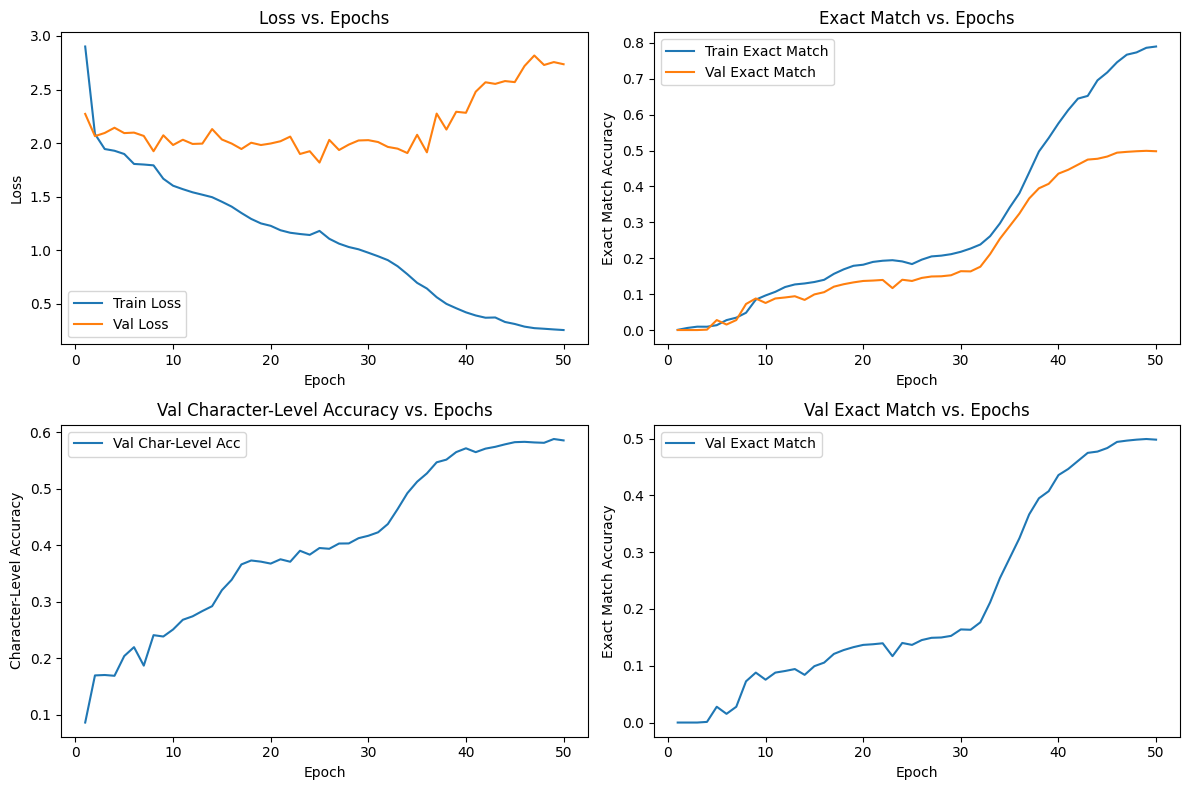

In [ ]:
# Model configuration
d_model = 256
num_layers = 4
num_heads = 8
d_ff = 1024
dropout = 0.1
max_len = 100
learning_rate = 5e-4
num_epochs = 50
# num_epochs = 75
patience = 5

# Initialize model
model = TransformerModel(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    d_ff=d_ff,
    dropout=dropout,
    max_len=max_len
).to(device)

# Set up loss and optimizer
loss_function = get_loss_function(pad_id)
optimizer = get_optimizer(model, learning_rate)

# Train
train_losses, val_losses, train_ems, val_ems, val_char_accs, val_perplexities = run_training(
    model,
    train_loader,
    val_loader,
    loss_function,
    optimizer,
    device,
    pad_id,
    num_epochs=num_epochs,
    patience=patience,
    save_path='best_model.pt'
)

## Final Evaluation on Test Sets

Evaluates the best model on Test 1 (longer digits), Test 2 (carry/borrow), and Test 3 (3 operands). Reports:
- Loss
- Exact Match Accuracy
- Character-Level Accuracy
- Perplexity
- Sample predictions (5 per test set)

In [ ]:
def evaluate_final_test_set(model, test_loader, loss_function, device, pad_id, model_path='best_model.pt', num_examples_to_print=5, test_name='Test'):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    test_loss, exact_match, char_acc, perplexity = evaluate_epoch(model, test_loader, loss_function, device, pad_id)

    print(f'{test_name} Performance:')
    print(f'  Test Loss       : {test_loss:.4f}')
    print(f'  Exact Match     : {exact_match:.4f}')
    print(f'  Char-Level Acc  : {char_acc:.4f}')
    print(f'  Perplexity      : {perplexity:.4f}')

    print(f'\nSample Predictions for {test_name}:\n')
    count = 0
    with torch.no_grad():
        for src_batch, tgt_input_batch, tgt_output_batch in test_loader:
            src_batch = src_batch.to(device)
            tgt_input_batch = tgt_input_batch.to(device)
            tgt_output_batch = tgt_output_batch.to(device)

            tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
            logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)

            for i in range(src_batch.size(0)):
                if count >= num_examples_to_print:
                    break
                input_str = decode_expression(src_batch[i].tolist(), id_to_token)
                pred_str = decode_expression(predictions[i].tolist(), id_to_token)
                gold_str = decode_expression(tgt_output_batch[i].tolist(), id_to_token)

                print(f'Input : {input_str}')
                print(f'Pred  : {pred_str}')
                print(f'Gold  : {gold_str}\n')
                count += 1
            if count >= num_examples_to_print:
                break

# Evaluate all test sets
evaluate_final_test_set(model, test1_loader, loss_function, device, pad_id, test_name='Test 1 (Long Operands)')
evaluate_final_test_set(model, test2_loader, loss_function, device, pad_id, test_name='Test 2 (Carry/Borrow)')
evaluate_final_test_set(model, test3_loader, loss_function, device, pad_id, test_name='Test 3 (Three Operands)')

Test 1 (Long Operands) Performance:
  Test Loss       : 3.6060
  Exact Match     : 0.0950
  Char-Level Acc  : 0.2316
  Perplexity      : 36.8203

Sample Predictions for Test 1 (Long Operands):

Input : 830044+3414798
Pred  : 1991
Gold  : 4244842

Input : 2615384-8603253
Pred  : -1211
Gold  : -5987869

Input : 9624806+553392
Pred  : 12119
Gold  : 10178198

Input : 7609139-3955945
Pred  : -18
Gold  : 3653194

Input : 960062+230602
Pred  : 12110
Gold  : 1190664

Test 2 (Carry/Borrow) Performance:
  Test Loss       : 4.1741
  Exact Match     : 0.1380
  Char-Level Acc  : 0.3799
  Perplexity      : 64.9783

Sample Predictions for Test 2 (Carry/Borrow):

Input : 999+1
Pred  : 1010
Gold  : 1000

Input : 99999+1
Pred  : 10090
Gold  : 100000

Input : 9999+1
Pred  : 10010
Gold  : 10000

Input : 999999+1
Pred  : 10090
Gold  : 1000000

Input : 99999+1
Pred  : 10090
Gold  : 100000

Test 3 (Three Operands) Performance:
  Test Loss       : 2.6438
  Exact Match     : 0.0955
  Char-Level Acc  : 0.3607
 

## Verification of dataset

In [ ]:
import os
import csv
import re
from pathlib import Path

# Directories
train_val_dir = "arithmetic_datasets_v3"
edge_case_dir = "arithmetic_datasets_edge_cases"
output_log = "dataset_errors.log"

# List of CSV files to check (excluding zero_cases.csv)
csv_files = [
    os.path.join(train_val_dir, "train.csv"),
    os.path.join(train_val_dir, "val.csv"),
    os.path.join(edge_case_dir, "test1.csv"),
    os.path.join(edge_case_dir, "test2.csv"),
    os.path.join(edge_case_dir, "test3.csv")
]

def safe_eval(expr):
    """Safely evaluate an arithmetic expression (e.g., '123+456-789') with left-to-right precedence."""
    try:
        # Replace multiple operators (e.g., '--' → '+', '+-' → '-')
        expr = expr.replace('--', '+').replace('+-', '-').replace('-+', '-').replace('++', '+')
        # Split into tokens (numbers and operators)
        tokens = re.findall(r'[+-]|\d+', expr)
        if not tokens or not tokens[0].lstrip('-').isdigit():
            return None
        # Compute left-to-right
        result = int(tokens[0])
        i = 1
        while i < len(tokens):
            op = tokens[i]
            if i + 1 >= len(tokens) or not tokens[i + 1].lstrip('-').isdigit():
                return None
            num = int(tokens[i + 1])
            if op == '+':
                result += num
            elif op == '-':
                result -= num
            i += 2
        return str(result)
    except Exception as e:
        print(f"Error evaluating {expr}: {e}")
        return None

def check_csv(file_path, max_samples=10000):
    """Check a CSV file for incorrect gold labels."""
    if not os.path.exists(file_path):
        print(f"File {file_path} not found.")
        return 0, []

    errors = []
    total_samples = 0
    try:
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            headers = next(reader)  # Skip header
            for row in reader:
                total_samples += 1
                if len(row) < 2:
                    errors.append((row, "Invalid row format"))
                    continue
                expr, gold = row[0], row[1]
                computed = safe_eval(expr)
                if computed is None:
                    errors.append((row, "Failed to compute result"))
                elif computed != gold:
                    errors.append((row, f"Computed: {computed}, Gold: {gold}"))
                if total_samples >= max_samples:
                    break
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return 0, []

    return total_samples, errors

def main():
    """Check all CSV files and log errors."""
    with open(output_log, 'w') as log:
        log.write("Dataset Verification Report\n")
        log.write("=" * 50 + "\n\n")

        for file_path in csv_files:
            print(f"Checking {file_path}...")
            total_samples, errors = check_csv(file_path)

            # Write to log
            log.write(f"File: {file_path}\n")
            log.write(f"Total Samples Checked: {total_samples}\n")
            log.write(f"Errors Found: {len(errors)}\n")
            if total_samples == 0:
                log.write("No samples found (file empty or missing).\n")
            elif errors:
                log.write("Sample Errors:\n")
                for row, error_msg in errors[:5]:  # Show up to 5 errors
                    log.write(f"Expression: {row[0]}, Gold: {row[1]}, Error: {error_msg}\n")
            log.write("\n")

            # Print summary
            print(f"  Total Samples: {total_samples}")
            if total_samples == 0:
                print("  No samples found (file empty or missing).")
            else:
                print(f"  Errors: {len(errors)} ({len(errors)/total_samples*100:.2f}%)")
                if errors:
                    print("  Sample Errors:")
                    for row, error_msg in errors[:3]:  # Show up to 3 errors in console
                        print(f"    Expr: {row[0]}, Gold: {row[1]}, Error: {error_msg}")
            print()

    print(f"Verification complete. Full report saved to {output_log}.")

if __name__ == "__main__":
    main()

Checking arithmetic_datasets_v3/train.csv...
  Total Samples: 10000
  Errors: 0 (0.00%)

Checking arithmetic_datasets_v3/val.csv...
  Total Samples: 1763
  Errors: 0 (0.00%)

Checking arithmetic_datasets_edge_cases/test1.csv...
  Total Samples: 2000
  Errors: 0 (0.00%)

Checking arithmetic_datasets_edge_cases/test2.csv...
  Total Samples: 2000
  Errors: 0 (0.00%)

Checking arithmetic_datasets_edge_cases/test3.csv...
  Total Samples: 2000
  Errors: 0 (0.00%)

Verification complete. Full report saved to dataset_errors.log.


## Ablation Study

**Removed Positional Encoding**

Using device: cuda
Vocabulary Size: 16
Tokens: {'<pad>': 0, '<sos>': 1, '<eos>': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '+': 13, '-': 14, '=': 15}
Loaded dataset with 26606 samples from arithmetic_datasets_v3/train.csv
Loaded dataset with 1763 samples from arithmetic_datasets_v3/val.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test1.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test2.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test3.csv
Train batches: 26
Validation batches: 2
Test 1 batches: 2
Test 2 batches: 2
Test 3 batches: 2
Epoch 01 | Time: 17.61s
  Train Loss     : 2.9896
  Val Loss       : 2.3696
  Train Exact Match: 0.0002
  Val Exact Match: 0.0000
  Val Char Acc   : 0.0572
  Val Perplexity : 10.6927
  No improvement.
Epoch 02 | Time: 17.04s
  Train Loss     : 2.1971
  Val Loss       : 2.2107
  Train Exact Match: 0.0039
  Val Exact Match: 0.0000
  V

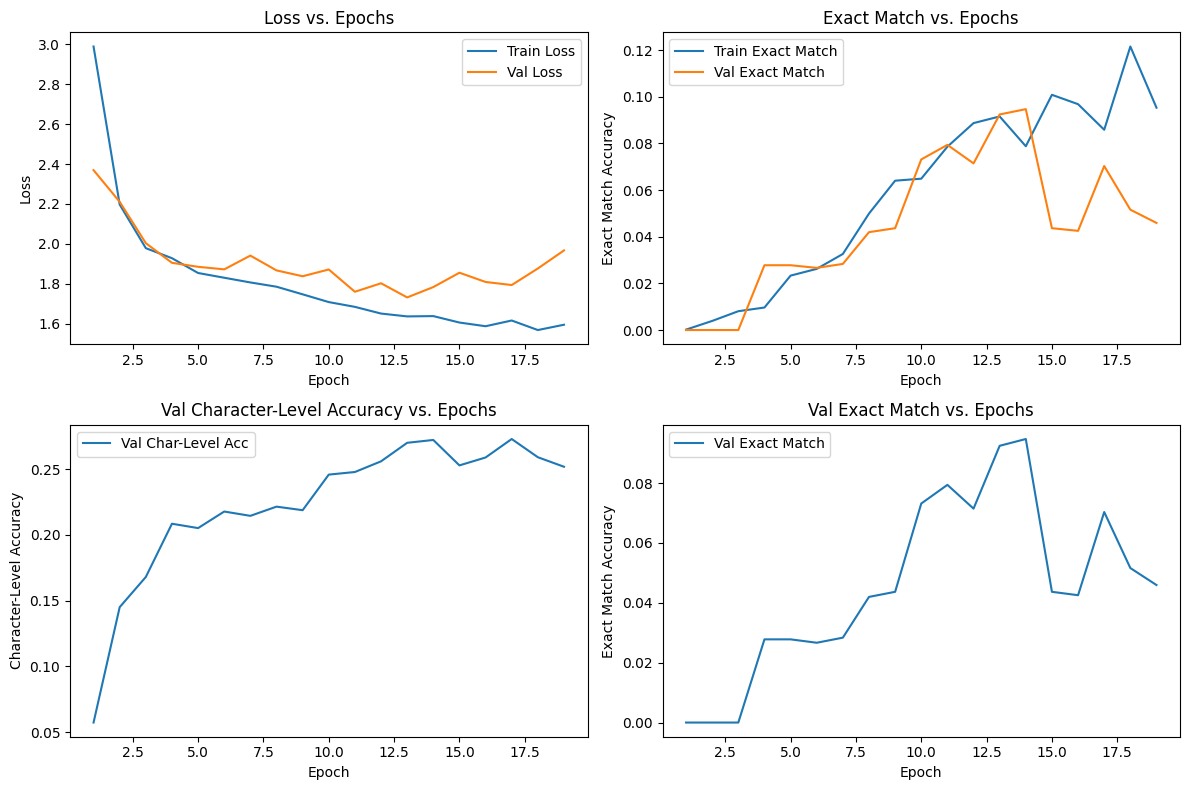

Test 1 (Long Operands) Performance:
  Test Loss       : 3.4032
  Exact Match     : 0.0000
  Char-Level Acc  : 0.1720
  Perplexity      : 30.0590

Sample Predictions for Test 1 (Long Operands):

Input : 830044+3414798
Pred  : 1449
Gold  : 4244842

Input : 2615384-8603253
Pred  : -1443
Gold  : -5987869

Input : 9624806+553392
Pred  : 10004
Gold  : 10178198

Input : 7609139-3955945
Pred  : -749
Gold  : 3653194

Input : 960062+230602
Pred  : 10023
Gold  : 1190664

Test 2 (Carry/Borrow) Performance:
  Test Loss       : 2.5932
  Exact Match     : 0.0000
  Char-Level Acc  : 0.2463
  Perplexity      : 13.3721

Sample Predictions for Test 2 (Carry/Borrow):

Input : 999+1
Pred  : 100
Gold  : 1000

Input : 99999+1
Pred  : 10009
Gold  : 100000

Input : 9999+1
Pred  : 1000
Gold  : 10000

Input : 999999+1
Pred  : 10009
Gold  : 1000000

Input : 99999+1
Pred  : 10009
Gold  : 100000

Test 3 (Three Operands) Performance:
  Test Loss       : 2.2800
  Exact Match     : 0.0000
  Char-Level Acc  : 0.2184
  

In [3]:
import os
import csv
import random
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import csv
import re
from pathlib import Path

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Dataset directories
train_val_dir = 'arithmetic_datasets_v3'
edge_case_dir = 'arithmetic_datasets_edge_cases'

# Ensure directories exist
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(edge_case_dir, exist_ok=True)

# Vocabulary and Special Tokens
vocab_symbols = ['<pad>', '<sos>', '<eos>'] + list('0123456789+-=')
vocab_size = len(vocab_symbols)
token_to_id = {token: idx for idx, token in enumerate(vocab_symbols)}
id_to_token = {idx: token for token, idx in token_to_id.items()}
pad_id = token_to_id['<pad>']
sos_id = token_to_id['<sos>']
eos_id = token_to_id['<eos>']
print('Vocabulary Size:', vocab_size)
print('Tokens:', token_to_id)

# Tokenization and Encoding
def encode_expression(expr, token_to_id, max_len=40, add_sos_eos=True):
    token_ids = []
    if add_sos_eos:
        token_ids.append(token_to_id['<sos>'])
    for char in expr:
        if char in token_to_id:
            token_ids.append(token_to_id[char])
        else:
            raise ValueError(f'Invalid character {char} in expression')
    if add_sos_eos:
        token_ids.append(token_to_id['<eos>'])
    if max_len is not None:
        if len(token_ids) < max_len:
            token_ids += [token_to_id['<pad>']] * (max_len - len(token_ids))
        else:
            token_ids = token_ids[:max_len]
    return torch.tensor(token_ids, dtype=torch.long)

def decode_expression(token_ids, id_to_token):
    tokens = []
    for idx in token_ids:
        token = id_to_token.get(idx, '')
        if token in ['<eos>', '<pad>', '<sos>']:
            if token == '<eos>':
                break
            continue
        tokens.append(token)
    return ''.join(tokens)

# Dataset Class and DataLoader
class ArithmeticDataset(Dataset):
    def __init__(self, csv_file, token_to_id, max_src_len=40, max_tgt_len=20):
        self.data = []
        self.token_to_id = token_to_id
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len
        try:
            with open(csv_file, 'r') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    self.data.append((row['expression'], row['result']))
        except Exception as e:
            raise ValueError(f'Error reading {csv_file}: {e}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        expr, result = self.data[idx]
        src_tensor = encode_expression(expr, self.token_to_id, self.max_src_len)
        tgt_full = encode_expression(result, self.token_to_id, self.max_tgt_len)
        tgt_input = tgt_full[:-1]
        tgt_output = tgt_full[1:]
        return src_tensor, tgt_input, tgt_output

def get_data_loader(csv_path, token_to_id, batch_size=1024, max_src_len=40, max_tgt_len=20, shuffle=True):
    dataset = ArithmeticDataset(csv_path, token_to_id, max_src_len, max_tgt_len)
    print(f'Loaded dataset with {len(dataset)} samples from {csv_path}')
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

# Load Train, Validation, and Test Data
train_loader = get_data_loader(os.path.join(train_val_dir, 'train.csv'), token_to_id)
val_loader = get_data_loader(os.path.join(train_val_dir, 'val.csv'), token_to_id)
test1_loader = get_data_loader(os.path.join(edge_case_dir, 'test1.csv'), token_to_id, shuffle=False)
test2_loader = get_data_loader(os.path.join(edge_case_dir, 'test2.csv'), token_to_id, shuffle=False)
test3_loader = get_data_loader(os.path.join(edge_case_dir, 'test3.csv'), token_to_id, shuffle=False)
print('Train batches:', len(train_loader))
print('Validation batches:', len(val_loader))
print('Test 1 batches:', len(test1_loader))
print('Test 2 batches:', len(test2_loader))
print('Test 3 batches:', len(test3_loader))

# === Model Definition (Positional Encoding Removed) ===

# FeedForward Network (Unchanged)
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU()
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Encoder Layer (Unchanged)
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.self_attention.in_proj_weight)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.self_attention(x, x, x, attn_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        x = self.norm2(x + self.dropout(self.feed_forward(x)))
        return x

# Decoder Layer (Unchanged)
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.cross_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.self_attention.in_proj_weight)
        nn.init.xavier_uniform_(self.cross_attention.in_proj_weight)

    def forward(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        self_attn_output, _ = self.self_attention(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        cross_attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, attn_mask=memory_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        x = self.norm3(x + self.dropout(self.feed_forward(x)))
        return x

# Encoder (Modified: Removed Positional Encoding)
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, src_tokens, src_mask=None):
        x = self.embedding(src_tokens) * math.sqrt(self.embedding.embedding_dim)
        # Removed: self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

# Decoder (Modified: Removed Positional Encoding)
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, tgt_tokens, encoder_output, tgt_mask=None, memory_mask=None):
        x = self.embedding(tgt_tokens) * math.sqrt(self.embedding.embedding_dim)
        # Removed: self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask, memory_mask)
        return x

# Transformer Model (Unchanged)
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_len)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, src_tokens, tgt_tokens, src_mask=None, tgt_mask=None, memory_mask=None):
        encoder_output = self.encoder(src_tokens, src_mask)
        decoder_output = self.decoder(tgt_tokens, encoder_output, tgt_mask, memory_mask)
        output_logits = self.output_layer(decoder_output)
        return output_logits

# Attention Masking
def create_padding_mask(token_batch, pad_token_id):
    return (token_batch == pad_token_id).unsqueeze(1).unsqueeze(2)

def create_subsequent_mask(seq_len):
    return torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()

# Loss Function and Optimizer
def get_loss_function(pad_token_id):
    return nn.CrossEntropyLoss(ignore_index=pad_token_id)

def get_optimizer(model, learning_rate=5e-4):
    return torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and Validation Loop
def train_epoch(model, dataloader, loss_function, optimizer, device, pad_id):
    model.train()
    total_loss = 0
    exact_match_count = 0
    total_samples = 0
    total_char_correct = 0
    total_char_total = 0
    for src_batch, tgt_input_batch, tgt_output_batch in dataloader:
        src_batch = src_batch.to(device)
        tgt_input_batch = tgt_input_batch.to(device)
        tgt_output_batch = tgt_output_batch.to(device)
        tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
        optimizer.zero_grad()
        logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)
        loss = loss_function(logits.view(-1, logits.size(-1)), tgt_output_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = logits.argmax(dim=-1)
        for pred, target in zip(predictions, tgt_output_batch):
            pred_str = decode_expression(pred.tolist(), id_to_token)
            target_str = decode_expression(target.tolist(), id_to_token)
            if pred_str == target_str:
                exact_match_count += 1
            total_char_correct += sum(p == t for p, t in zip(pred_str, target_str))
            total_char_total += max(len(pred_str), len(target_str))
            total_samples += 1
    avg_loss = total_loss / len(dataloader)
    exact_match = exact_match_count / total_samples if total_samples > 0 else 0
    char_acc = total_char_correct / total_char_total if total_char_total > 0 else 0
    return avg_loss, exact_match, char_acc

def evaluate_epoch(model, dataloader, loss_function, device, pad_id):
    model.eval()
    total_loss = 0
    exact_match_count = 0
    total_samples = 0
    total_char_correct = 0
    total_char_total = 0
    with torch.no_grad():
        for src_batch, tgt_input_batch, tgt_output_batch in dataloader:
            src_batch = src_batch.to(device)
            tgt_input_batch = tgt_input_batch.to(device)
            tgt_output_batch = tgt_output_batch.to(device)
            tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
            logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)
            loss = loss_function(logits.view(-1, logits.size(-1)), tgt_output_batch.view(-1))
            total_loss += loss.item()
            predictions = logits.argmax(dim=-1)
            for pred, target in zip(predictions, tgt_output_batch):
                pred_str = decode_expression(pred.tolist(), id_to_token)
                target_str = decode_expression(target.tolist(), id_to_token)
                if pred_str == target_str:
                    exact_match_count += 1
                total_char_correct += sum(p == t for p, t in zip(pred_str, target_str))
                total_char_total += max(len(pred_str), len(target_str))
                total_samples += 1
    avg_loss = total_loss / len(dataloader)
    exact_match = exact_match_count / total_samples if total_samples > 0 else 0
    char_acc = total_char_correct / total_char_total if total_char_total > 0 else 0
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, exact_match, char_acc, perplexity

def run_training(model, train_loader, val_loader, loss_function, optimizer, device, pad_id, num_epochs=50, patience=5, save_path='best_model.pt'):
    best_exact_match = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_exact_matches = []
    val_exact_matches = []
    val_char_accs = []
    val_perplexities = []
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        train_loss, train_exact_match, train_char_acc = train_epoch(model, train_loader, loss_function, optimizer, device, pad_id)
        val_loss, val_exact_match, val_char_acc, val_perplexity = evaluate_epoch(model, val_loader, loss_function, device, pad_id)
        elapsed = time.time() - start_time
        print(f'Epoch {epoch:02d} | Time: {elapsed:.2f}s')
        print(f'  Train Loss     : {train_loss:.4f}')
        print(f'  Val Loss       : {val_loss:.4f}')
        print(f'  Train Exact Match: {train_exact_match:.4f}')
        print(f'  Val Exact Match: {val_exact_match:.4f}')
        print(f'  Val Char Acc   : {val_char_acc:.4f}')
        print(f'  Val Perplexity : {val_perplexity:.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_exact_matches.append(train_exact_match)
        val_exact_matches.append(val_exact_match)
        val_char_accs.append(val_char_acc)
        val_perplexities.append(val_perplexity)
        if val_exact_match > best_exact_match:
            best_exact_match = val_exact_match
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print('  Saved new best model.')
        else:
            patience_counter += 1
            print('  No improvement.')
        if patience_counter >= patience:
            print(f'Early stopping triggered after {patience} epochs without improvement.')
            break
    # Plotting
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_exact_matches, label='Train Exact Match')
    plt.plot(epochs, val_exact_matches, label='Val Exact Match')
    plt.xlabel('Epoch')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Exact Match vs. Epochs')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_char_accs, label='Val Char-Level Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Character-Level Accuracy')
    plt.title('Val Character-Level Accuracy vs. Epochs')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_exact_matches, label='Val Exact Match')
    plt.xlabel('Epoch')
    plt.ylabel('Exact Match Accuracy')
    plt.title('Val Exact Match vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return train_losses, val_losses, train_exact_matches, val_exact_matches, val_char_accs, val_perplexities

# Main Training Script
# Model configuration
d_model = 256
num_layers = 4
num_heads = 8
d_ff = 1024
dropout = 0.1
max_len = 100
learning_rate = 5e-4
num_epochs = 50
patience = 5

# Initialize model
model = TransformerModel(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    d_ff=d_ff,
    dropout=dropout,
    max_len=max_len
).to(device)

# Set up loss and optimizer
loss_function = get_loss_function(pad_id)
optimizer = get_optimizer(model, learning_rate)

# Train (Uncomment to run)

train_losses, val_losses, train_ems, val_ems, val_char_accs, val_perplexities = run_training(
    model,
    train_loader,
    val_loader,
    loss_function,
    optimizer,
    device,
    pad_id,
    num_epochs=num_epochs,
    patience=patience,
    save_path='best_model.pt'
)

# Final Evaluation on Test Sets
def evaluate_final_test_set(model, test_loader, loss_function, device, pad_id, model_path='best_model.pt', num_examples_to_print=5, test_name='Test'):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    test_loss, exact_match, char_acc, perplexity = evaluate_epoch(model, test_loader, loss_function, device, pad_id)
    print(f'{test_name} Performance:')
    print(f'  Test Loss       : {test_loss:.4f}')
    print(f'  Exact Match     : {exact_match:.4f}')
    print(f'  Char-Level Acc  : {char_acc:.4f}')
    print(f'  Perplexity      : {perplexity:.4f}')
    print(f'\nSample Predictions for {test_name}:\n')
    count = 0
    with torch.no_grad():
        for src_batch, tgt_input_batch, tgt_output_batch in test_loader:
            src_batch = src_batch.to(device)
            tgt_input_batch = tgt_input_batch.to(device)
            tgt_output_batch = tgt_output_batch.to(device)
            tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
            logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            for i in range(src_batch.size(0)):
                if count >= num_examples_to_print:
                    break
                input_str = decode_expression(src_batch[i].tolist(), id_to_token)
                pred_str = decode_expression(predictions[i].tolist(), id_to_token)
                gold_str = decode_expression(tgt_output_batch[i].tolist(), id_to_token)
                print(f'Input : {input_str}')
                print(f'Pred  : {pred_str}')
                print(f'Gold  : {gold_str}\n')
                count += 1
            if count >= num_examples_to_print:
                break

# Evaluate all test sets (Uncomment to run after training)

evaluate_final_test_set(model, test1_loader, loss_function, device, pad_id, test_name='Test 1 (Long Operands)')
evaluate_final_test_set(model, test2_loader, loss_function, device, pad_id, test_name='Test 2 (Carry/Borrow)')
evaluate_final_test_set(model, test3_loader, loss_function, device, pad_id, test_name='Test 3 (Three Operands)')


# Verification of Dataset
output_log = "dataset_errors.log"
csv_files = [
    os.path.join(train_val_dir, "train.csv"),
    os.path.join(train_val_dir, "val.csv"),
    os.path.join(edge_case_dir, "test1.csv"),
    os.path.join(edge_case_dir, "test2.csv"),
    os.path.join(edge_case_dir, "test3.csv")
]

def safe_eval(expr):
    try:
        expr = expr.replace('--', '+').replace('+-', '-').replace('-+', '-').replace('++', '+')
        tokens = re.findall(r'[+-]|\d+', expr)
        if not tokens or not tokens[0].lstrip('-').isdigit():
            return None
        result = int(tokens[0])
        i = 1
        while i < len(tokens):
            op = tokens[i]
            if i + 1 >= len(tokens) or not tokens[i + 1].lstrip('-').isdigit():
                return None
            num = int(tokens[i + 1])
            if op == '+':
                result += num
            elif op == '-':
                result -= num
            i += 2
        return str(result)
    except Exception as e:
        print(f"Error evaluating {expr}: {e}")
        return None

def check_csv(file_path, max_samples=10000):
    if not os.path.exists(file_path):
        print(f"File {file_path} not found.")
        return 0, []
    errors = []
    total_samples = 0
    try:
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            headers = next(reader)
            for row in reader:
                total_samples += 1
                if len(row) < 2:
                    errors.append((row, "Invalid row format"))
                    continue
                expr, gold = row[0], row[1]
                computed = safe_eval(expr)
                if computed is None:
                    errors.append((row, "Failed to compute result"))
                elif computed != gold:
                    errors.append((row, f"Computed: {computed}, Gold: {gold}"))
                if total_samples >= max_samples:
                    break
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return 0, []
    return total_samples, errors

def main():
    with open(output_log, 'w') as log:
        log.write("Dataset Verification Report\n")
        log.write("=" * 50 + "\n\n")
        for file_path in csv_files:
            print(f"Checking {file_path}...")
            total_samples, errors = check_csv(file_path)
            log.write(f"File: {file_path}\n")
            log.write(f"Total Samples Checked: {total_samples}\n")
            log.write(f"Errors Found: {len(errors)}\n")
            if total_samples == 0:
                log.write("No samples found (file empty or missing).\n")
            elif errors:
                log.write("Sample Errors:\n")
                for row, error_msg in errors[:5]:
                    log.write(f"Expression: {row[0]}, Gold: {row[1]}, Error: {error_msg}\n")
            log.write("\n")
            print(f"  Total Samples: {total_samples}")
            if total_samples == 0:
                print("  No samples found (file empty or missing).")
            else:
                print(f"  Errors: {len(errors)} ({len(errors)/total_samples*100:.2f}%)")
                if errors:
                    print("  Sample Errors:")
                    for row, error_msg in errors[:3]:
                        print(f"    Expr: {row[0]}, Gold: {row[1]}, Error: {error_msg}")
            print()
    print(f"Verification complete. Full report saved to {output_log}.")

if __name__ == "__main__":
    main()

## Ablation Study with Number of Attention Heads

Using device: cuda
Vocabulary Size: 16
Tokens: {'<pad>': 0, '<sos>': 1, '<eos>': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '+': 13, '-': 14, '=': 15}
Loaded dataset with 26606 samples from arithmetic_datasets_v3/train.csv
Loaded dataset with 1763 samples from arithmetic_datasets_v3/val.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test1.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test2.csv
Loaded dataset with 2000 samples from arithmetic_datasets_edge_cases/test3.csv
Train batches: 26
Validation batches: 2
Test 1 batches: 2
Test 2 batches: 2
Test 3 batches: 2
Checking arithmetic_datasets_v3/train.csv...
  Total Samples: 10000
  Errors: 0 (0.00%)

Checking arithmetic_datasets_v3/val.csv...
  Total Samples: 1763
  Errors: 0 (0.00%)

Checking arithmetic_datasets_edge_cases/test1.csv...
  Total Samples: 2000
  Errors: 0 (0.00%)

Checking arithmetic_datasets_edge_cases/test2.csv...
  Total Sa

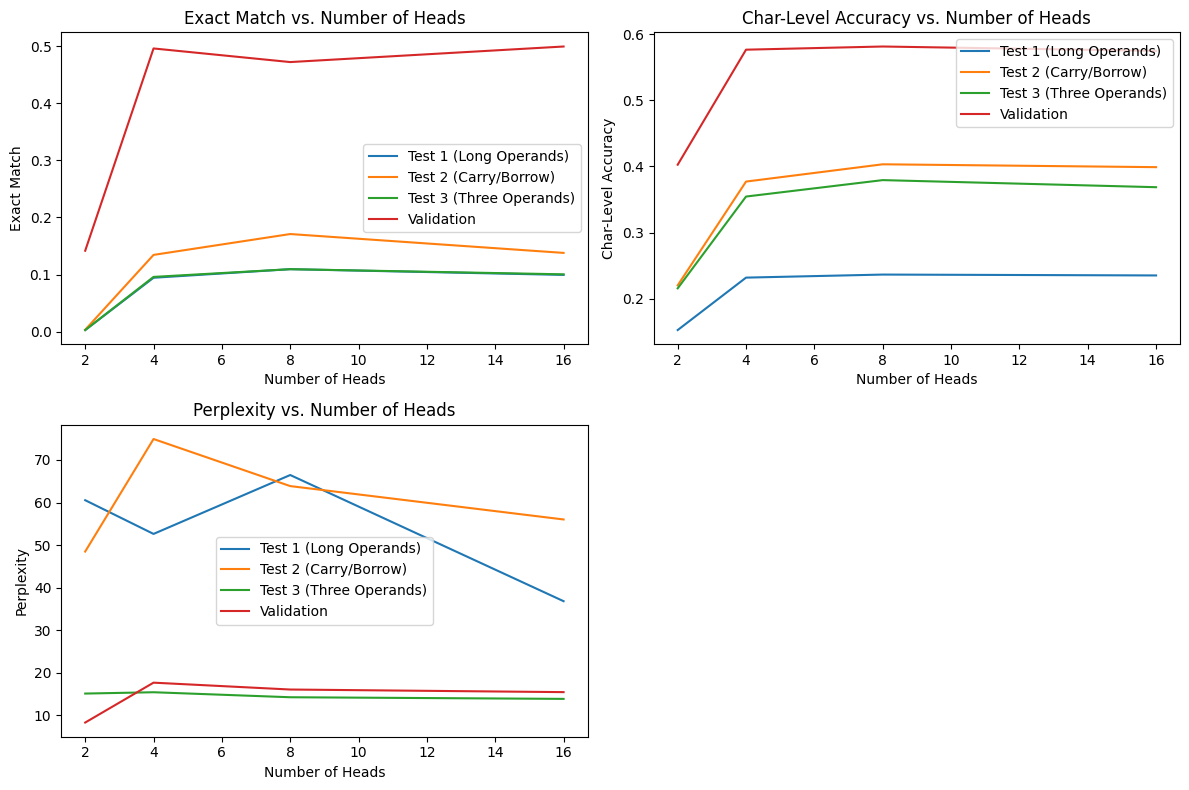

In [3]:
import os
import csv
import random
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import re
from pathlib import Path

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Dataset directories
train_val_dir = 'arithmetic_datasets_v3'
edge_case_dir = 'arithmetic_datasets_edge_cases'

# Ensure directories exist
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(edge_case_dir, exist_ok=True)

# Vocabulary and Special Tokens
vocab_symbols = ['<pad>', '<sos>', '<eos>'] + list('0123456789+-=')
vocab_size = len(vocab_symbols)
token_to_id = {token: idx for idx, token in enumerate(vocab_symbols)}
id_to_token = {idx: token for token, idx in token_to_id.items()}
pad_id = token_to_id['<pad>']
sos_id = token_to_id['<sos>']
eos_id = token_to_id['<eos>']
print('Vocabulary Size:', vocab_size)
print('Tokens:', token_to_id)

# Tokenization and Encoding
def encode_expression(expr, token_to_id, max_len=40, add_sos_eos=True):
    token_ids = []
    if add_sos_eos:
        token_ids.append(token_to_id['<sos>'])
    for char in expr:
        if char in token_to_id:
            token_ids.append(token_to_id[char])
        else:
            raise ValueError(f'Invalid character {char} in expression')
    if add_sos_eos:
        token_ids.append(token_to_id['<eos>'])
    if max_len is not None:
        if len(token_ids) < max_len:
            token_ids += [token_to_id['<pad>']] * (max_len - len(token_ids))
        else:
            token_ids = token_ids[:max_len]
    return torch.tensor(token_ids, dtype=torch.long)

def decode_expression(token_ids, id_to_token):
    tokens = []
    for idx in token_ids:
        token = id_to_token.get(idx, '')
        if token in ['<eos>', '<pad>', '<sos>']:
            if token == '<eos>':
                break
            continue
        tokens.append(token)
    return ''.join(tokens)

# Dataset Class and DataLoader
class ArithmeticDataset(Dataset):
    def __init__(self, csv_file, token_to_id, max_src_len=40, max_tgt_len=20):
        self.data = []
        self.token_to_id = token_to_id
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len
        try:
            with open(csv_file, 'r') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    self.data.append((row['expression'], row['result']))
        except Exception as e:
            raise ValueError(f'Error reading {csv_file}: {e}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        expr, result = self.data[idx]
        src_tensor = encode_expression(expr, self.token_to_id, self.max_src_len)
        tgt_full = encode_expression(result, self.token_to_id, self.max_tgt_len)
        tgt_input = tgt_full[:-1]
        tgt_output = tgt_full[1:]
        return src_tensor, tgt_input, tgt_output

def get_data_loader(csv_path, token_to_id, batch_size=1024, max_src_len=40, max_tgt_len=20, shuffle=True):
    dataset = ArithmeticDataset(csv_path, token_to_id, max_src_len, max_tgt_len)
    print(f'Loaded dataset with {len(dataset)} samples from {csv_path}')
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

# Load Train, Validation, and Test Data
train_loader = get_data_loader(os.path.join(train_val_dir, 'train.csv'), token_to_id)
val_loader = get_data_loader(os.path.join(train_val_dir, 'val.csv'), token_to_id)
test1_loader = get_data_loader(os.path.join(edge_case_dir, 'test1.csv'), token_to_id, shuffle=False)
test2_loader = get_data_loader(os.path.join(edge_case_dir, 'test2.csv'), token_to_id, shuffle=False)
test3_loader = get_data_loader(os.path.join(edge_case_dir, 'test3.csv'), token_to_id, shuffle=False)
print('Train batches:', len(train_loader))
print('Validation batches:', len(val_loader))
print('Test 1 batches:', len(test1_loader))
print('Test 2 batches:', len(test2_loader))
print('Test 3 batches:', len(test3_loader))

# === Positional Encoding ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

# FeedForward Network (Unchanged)
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU()
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Encoder Layer (Unchanged)
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.self_attention.in_proj_weight)

    def forward(self, x, src_mask=None):
        attn_output, _ = self.self_attention(x, x, x, attn_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        x = self.norm2(x + self.dropout(self.feed_forward(x)))
        return x

# Decoder Layer (Unchanged)
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.cross_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.self_attention.in_proj_weight)
        nn.init.xavier_uniform_(self.cross_attention.in_proj_weight)

    def forward(self, x, encoder_output, tgt_mask=None, memory_mask=None):
        self_attn_output, _ = self.self_attention(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        cross_attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, attn_mask=memory_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        x = self.norm3(x + self.dropout(self.feed_forward(x)))
        return x

# Encoder (Added Positional Encoding)
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, src_tokens, src_mask=None):
        x = self.embedding(src_tokens) * math.sqrt(self.embedding.embedding_dim)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

# Decoder (Added Positional Encoding)
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, tgt_tokens, encoder_output, tgt_mask=None, memory_mask=None):
        x = self.embedding(tgt_tokens) * math.sqrt(self.embedding.embedding_dim)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask, memory_mask)
        return x

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1, max_len=100):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout, max_len)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, src_tokens, tgt_tokens, src_mask=None, tgt_mask=None, memory_mask=None):
        encoder_output = self.encoder(src_tokens, src_mask)
        decoder_output = self.decoder(tgt_tokens, encoder_output, tgt_mask, memory_mask)
        output_logits = self.output_layer(decoder_output)
        return output_logits

# Attention Masking
def create_padding_mask(token_batch, pad_token_id):
    return (token_batch == pad_token_id).unsqueeze(1).unsqueeze(2)

def create_subsequent_mask(seq_len):
    return torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()

# Loss Function and Optimizer
def get_loss_function(pad_token_id):
    return nn.CrossEntropyLoss(ignore_index=pad_token_id)

def get_optimizer(model, learning_rate=5e-4):
    return torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and Validation Loop
def train_epoch(model, dataloader, loss_function, optimizer, device, pad_id):
    model.train()
    total_loss = 0
    exact_match_count = 0
    total_samples = 0
    total_char_correct = 0
    total_char_total = 0
    for src_batch, tgt_input_batch, tgt_output_batch in dataloader:
        src_batch = src_batch.to(device)
        tgt_input_batch = tgt_input_batch.to(device)
        tgt_output_batch = tgt_output_batch.to(device)
        tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
        optimizer.zero_grad()
        logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)
        loss = loss_function(logits.view(-1, logits.size(-1)), tgt_output_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = logits.argmax(dim=-1)
        for pred, target in zip(predictions, tgt_output_batch):
            pred_str = decode_expression(pred.tolist(), id_to_token)
            target_str = decode_expression(target.tolist(), id_to_token)
            if pred_str == target_str:
                exact_match_count += 1
            total_char_correct += sum(p == t for p, t in zip(pred_str, target_str))
            total_char_total += max(len(pred_str), len(target_str))
            total_samples += 1
    avg_loss = total_loss / len(dataloader)
    exact_match = exact_match_count / total_samples if total_samples > 0 else 0
    char_acc = total_char_correct / total_char_total if total_char_total > 0 else 0
    return avg_loss, exact_match, char_acc

def evaluate_epoch(model, dataloader, loss_function, device, pad_id):
    model.eval()
    total_loss = 0
    exact_match_count = 0
    total_samples = 0
    total_char_correct = 0
    total_char_total = 0
    with torch.no_grad():
        for src_batch, tgt_input_batch, tgt_output_batch in dataloader:
            src_batch = src_batch.to(device)
            tgt_input_batch = tgt_input_batch.to(device)
            tgt_output_batch = tgt_output_batch.to(device)
            tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
            logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)
            loss = loss_function(logits.view(-1, logits.size(-1)), tgt_output_batch.view(-1))
            total_loss += loss.item()
            predictions = logits.argmax(dim=-1)
            for pred, target in zip(predictions, tgt_output_batch):
                pred_str = decode_expression(pred.tolist(), id_to_token)
                target_str = decode_expression(target.tolist(), id_to_token)
                if pred_str == target_str:
                    exact_match_count += 1
                total_char_correct += sum(p == t for p, t in zip(pred_str, target_str))
                total_char_total += max(len(pred_str), len(target_str))
                total_samples += 1
    avg_loss = total_loss / len(dataloader)
    exact_match = exact_match_count / total_samples if total_samples > 0 else 0
    char_acc = total_char_correct / total_char_total if total_char_total > 0 else 0
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, exact_match, char_acc, perplexity

def run_training(model, train_loader, val_loader, loss_function, optimizer, device, pad_id, num_epochs=50, patience=5, save_path='best_model.pt'):
    best_exact_match = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_exact_matches = []
    val_exact_matches = []
    val_char_accs = []
    val_perplexities = []
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        train_loss, train_exact_match, train_char_acc = train_epoch(model, train_loader, loss_function, optimizer, device, pad_id)
        val_loss, val_exact_match, val_char_acc, val_perplexity = evaluate_epoch(model, val_loader, loss_function, device, pad_id)
        elapsed = time.time() - start_time
        print(f'Epoch {epoch:02d} | Time: {elapsed:.2f}s')
        print(f'  Train Loss     : {train_loss:.4f}')
        print(f'  Val Loss       : {val_loss:.4f}')
        print(f'  Train Exact Match: {train_exact_match:.4f}')
        print(f'  Val Exact Match: {val_exact_match:.4f}')
        print(f'  Val Char Acc   : {val_char_acc:.4f}')
        print(f'  Val Perplexity : {val_perplexity:.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_exact_matches.append(train_exact_match)
        val_exact_matches.append(val_exact_match)
        val_char_accs.append(val_char_acc)
        val_perplexities.append(val_perplexity)
        if val_exact_match > best_exact_match:
            best_exact_match = val_exact_match
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print('  Saved new best model.')
        else:
            patience_counter += 1
            print('  No improvement.')
        if patience_counter >= patience:
            print(f'Early stopping triggered after {patience} epochs without improvement.')
            break
    return train_losses, val_losses, train_exact_matches, val_exact_matches, val_char_accs, val_perplexities

def evaluate_final_test_set(model, test_loader, loss_function, device, pad_id, model_path='best_model.pt', num_examples_to_print=5, test_name='Test'):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    test_loss, exact_match, char_acc, perplexity = evaluate_epoch(model, test_loader, loss_function, device, pad_id)
    print(f'{test_name} Performance:')
    print(f'  Test Loss       : {test_loss:.4f}')
    print(f'  Exact Match     : {exact_match:.4f}')
    print(f'  Char-Level Acc  : {char_acc:.4f}')
    print(f'  Perplexity      : {perplexity:.4f}')
    print(f'\nSample Predictions for {test_name}:\n')
    count = 0
    with torch.no_grad():
        for src_batch, tgt_input_batch, tgt_output_batch in test_loader:
            src_batch = src_batch.to(device)
            tgt_input_batch = tgt_input_batch.to(device)
            tgt_output_batch = tgt_output_batch.to(device)
            tgt_mask = create_subsequent_mask(tgt_input_batch.size(1))
            logits = model(src_batch, tgt_input_batch, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            for i in range(src_batch.size(0)):
                if count >= num_examples_to_print:
                    break
                input_str = decode_expression(src_batch[i].tolist(), id_to_token)
                pred_str = decode_expression(predictions[i].tolist(), id_to_token)
                gold_str = decode_expression(tgt_output_batch[i].tolist(), id_to_token)
                print(f'Input : {input_str}')
                print(f'Pred  : {pred_str}')
                print(f'Gold  : {gold_str}\n')
                count += 1
            if count >= num_examples_to_print:
                break
    return exact_match, char_acc, perplexity

# Ablation Study: Vary Number of Attention Heads
def run_ablation_study(num_heads_list, train_loader, val_loader, test_loaders, device, pad_id):
    # Model configuration
    d_model = 256
    num_layers = 4
    d_ff = 1024
    dropout = 0.1
    max_len = 100
    learning_rate = 5e-4
    num_epochs = 50
    patience = 5

    results = []

    for num_heads in num_heads_list:
        if d_model % num_heads != 0:
            print(f'Skipping num_heads={num_heads} (d_model={d_model} must be divisible by num_heads)')
            continue

        print(f'\n=== Training with {num_heads} Attention Heads ===')
        save_path = f'best_model_heads_{num_heads}.pt'

        # Initialize model
        model = TransformerModel(
            src_vocab_size=vocab_size,
            tgt_vocab_size=vocab_size,
            d_model=d_model,
            num_layers=num_layers,
            num_heads=num_heads,
            d_ff=d_ff,
            dropout=dropout,
            max_len=max_len
        ).to(device)

        # Set up loss and optimizer
        loss_function = get_loss_function(pad_id)
        optimizer = get_optimizer(model, learning_rate)

        # Train
        train_losses, val_losses, train_ems, val_ems, val_char_accs, val_perplexities = run_training(
            model,
            train_loader,
            val_loader,
            loss_function,
            optimizer,
            device,
            pad_id,
            num_epochs=num_epochs,
            patience=patience,
            save_path=save_path
        )

        # Evaluate on validation set
        val_loss, val_exact_match, val_char_acc, val_perplexity = evaluate_epoch(model, val_loader, loss_function, device, pad_id)
        print(f'Validation Performance (num_heads={num_heads}):')
        print(f'  Val Loss       : {val_loss:.4f}')
        print(f'  Val Exact Match: {val_exact_match:.4f}')
        print(f'  Val Char Acc   : {val_char_acc:.4f}')
        print(f'  Val Perplexity : {val_perplexity:.4f}')

        # Evaluate on test sets
        test_results = {}
        for test_loader, test_name in test_loaders:
            exact_match, char_acc, perplexity = evaluate_final_test_set(
                model, test_loader, loss_function, device, pad_id,
                model_path=save_path, num_examples_to_print=5, test_name=test_name
            )
            test_results[test_name] = {
                'exact_match': exact_match,
                'char_acc': char_acc,
                'perplexity': perplexity
            }

        # Store results
        results.append({
            'num_heads': num_heads,
            'val_exact_match': val_exact_match,
            'val_char_acc': val_char_acc,
            'val_perplexity': val_perplexity,
            'test_results': test_results
        })

    # Print summary
    print('\n=== Ablation Study Summary ===')
    for result in results:
        print(f'\nNumber of Heads: {result["num_heads"]}')
        print(f'Validation Exact Match: {result["val_exact_match"]:.4f}')
        print(f'Validation Char Acc   : {result["val_char_acc"]:.4f}')
        print(f'Validation Perplexity: {result["val_perplexity"]:.4f}')
        for test_name, metrics in result['test_results'].items():
            print(f'{test_name}:')
            print(f'  Exact Match: {metrics["exact_match"]:.4f}')
            print(f'  Char Acc   : {metrics["char_acc"]:.4f}')
            print(f'  Perplexity : {metrics["perplexity"]:.4f}')

    # Plot results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    for test_name in [t[1] for t in test_loaders]:
        plt.plot([r['num_heads'] for r in results], [r['test_results'][test_name]['exact_match'] for r in results], label=test_name)
    plt.plot([r['num_heads'] for r in results], [r['val_exact_match'] for r in results], label='Validation')
    plt.xlabel('Number of Heads')
    plt.ylabel('Exact Match')
    plt.title('Exact Match vs. Number of Heads')
    plt.legend()

    plt.subplot(2, 2, 2)
    for test_name in [t[1] for t in test_loaders]:
        plt.plot([r['num_heads'] for r in results], [r['test_results'][test_name]['char_acc'] for r in results], label=test_name)
    plt.plot([r['num_heads'] for r in results], [r['val_char_acc'] for r in results], label='Validation')
    plt.xlabel('Number of Heads')
    plt.ylabel('Char-Level Accuracy')
    plt.title('Char-Level Accuracy vs. Number of Heads')
    plt.legend()

    plt.subplot(2, 2, 3)
    for test_name in [t[1] for t in test_loaders]:
        plt.plot([r['num_heads'] for r in results], [r['test_results'][test_name]['perplexity'] for r in results], label=test_name)
    plt.plot([r['num_heads'] for r in results], [r['val_perplexity'] for r in results], label='Validation')
    plt.xlabel('Number of Heads')
    plt.ylabel('Perplexity')
    plt.title('Perplexity vs. Number of Heads')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

# Verification of Dataset
output_log = "dataset_errors.log"
csv_files = [
    os.path.join(train_val_dir, "train.csv"),
    os.path.join(train_val_dir, "val.csv"),
    os.path.join(edge_case_dir, "test1.csv"),
    os.path.join(edge_case_dir, "test2.csv"),
    os.path.join(edge_case_dir, "test3.csv")
]

def safe_eval(expr):
    try:
        expr = expr.replace('--', '+').replace('+-', '-').replace('-+', '-').replace('++', '+')
        tokens = re.findall(r'[+-]|\d+', expr)
        if not tokens or not tokens[0].lstrip('-').isdigit():
            return None
        result = int(tokens[0])
        i = 1
        while i < len(tokens):
            op = tokens[i]
            if i + 1 >= len(tokens) or not tokens[i + 1].lstrip('-').isdigit():
                return None
            num = int(tokens[i + 1])
            if op == '+':
                result += num
            elif op == '-':
                result -= num
            i += 2
        return str(result)
    except Exception as e:
        print(f"Error evaluating {expr}: {e}")
        return None

def check_csv(file_path, max_samples=10000):
    if not os.path.exists(file_path):
        print(f"File {file_path} not found.")
        return 0, []
    errors = []
    total_samples = 0
    try:
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            headers = next(reader)
            for row in reader:
                total_samples += 1
                if len(row) < 2:
                    errors.append((row, "Invalid row format"))
                expr, gold = row[0], row[1]
                computed = safe_eval(expr)
                if computed is None:
                    errors.append((row, "Failed to compute result"))
                elif computed != gold:
                    errors.append((row, f"Computed: {computed}, Gold: {gold}"))
                if total_samples >= max_samples:
                    break
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return 0, []
    return total_samples, errors

def verify_dataset():
    with open(output_log, 'w') as log:
        log.write("Dataset Verification Report\n")
        log.write("=" * 50 + "\n\n")
        for file_path in csv_files:
            print(f"Checking {file_path}...")
            total_samples, errors = check_csv(file_path)
            log.write(f"File: {file_path}\n")
            log.write(f"Total Samples Checked: {total_samples}\n")
            log.write(f"Errors Found: {len(errors)}\n")
            if total_samples == 0:
                log.write("No samples found (file empty or missing).\n")
            elif errors:
                log.write("Sample Errors:\n")
                for row, error_msg in errors[:5]:
                    log.write(f"Expression: {row[0]}, Gold: {row[1]}, Error: {error_msg}\n")
            log.write("\n")
            print(f"  Total Samples: {total_samples}")
            if total_samples == 0:
                print("  No samples found (file empty or missing).")
            else:
                print(f"  Errors: {len(errors)} ({len(errors)/total_samples*100:.2f}%)")
                if errors:
                    print("  Sample Errors:")
                    for row, error_msg in errors[:3]:
                        print(f"    Expr: {row[0]}, Gold: {row[1]}, Error: {error_msg}")
            print()
    print(f"Verification complete. Full report saved to {output_log}.")

# Main Script
def main():
    # Verify dataset
    verify_dataset()

    # Define test loaders and names
    test_loaders = [
        (test1_loader, 'Test 1 (Long Operands)'),
        (test2_loader, 'Test 2 (Carry/Borrow)'),
        (test3_loader, 'Test 3 (Three Operands)')
    ]

    # Run ablation study with different numbers of attention heads
    num_heads_list = [2, 4, 8, 16]  # d_model=256 is divisible by these
    results = run_ablation_study(num_heads_list, train_loader, val_loader, test_loaders, device, pad_id)

    # Save results to a file
    with open('ablation_study_results.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Num Heads', 'Val Exact Match', 'Val Char Acc', 'Val Perplexity',
                         'Test 1 Exact Match', 'Test 1 Char Acc', 'Test 1 Perplexity',
                         'Test 2 Exact Match', 'Test 2 Char Acc', 'Test 2 Perplexity',
                         'Test 3 Exact Match', 'Test 3 Char Acc', 'Test 3 Perplexity'])
        for r in results:
            writer.writerow([
                r['num_heads'],
                r['val_exact_match'],
                r['val_char_acc'],
                r['val_perplexity'],
                r['test_results']['Test 1 (Long Operands)']['exact_match'],
                r['test_results']['Test 1 (Long Operands)']['char_acc'],
                r['test_results']['Test 1 (Long Operands)']['perplexity'],
                r['test_results']['Test 2 (Carry/Borrow)']['exact_match'],
                r['test_results']['Test 2 (Carry/Borrow)']['char_acc'],
                r['test_results']['Test 2 (Carry/Borrow)']['perplexity'],
                r['test_results']['Test 3 (Three Operands)']['exact_match'],
                r['test_results']['Test 3 (Three Operands)']['char_acc'],
                r['test_results']['Test 3 (Three Operands)']['perplexity']
            ])

if __name__ == "__main__":
    main()